In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import hdbscan
import nltk
import spacy

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

spaci = spacy.load("en_core_web_sm")

In [2]:
df = pd.read_csv('hsbc_twitter_DATA_not GENERAL.csv')
df.rename(columns={"NEW HUMAN CATEGORY\n 0-1000 /4000-4468 Michael\n 1000-2500 Mehmet \n 2500-4000 Aryamaan":"labels"}, inplace = True)
df.head()

tweet  \
0   2  @LondOgrad Hello Eugene, we do apologise for t...   
1   8  @ncohen4 @CooperativeBank @HSBC @HSBCUKBusines...   
2   9  @sharaola Good morning, sorry for your experie...   
3  11        @Bounce_BackLoan Still not a peep from HSBC   
4  15  @djm2481 @mgcmitchell @HSBC_UK Thanks for the ...   

  HUMAN CATEGORY\n ARYAMAAN:1-1000,4000-4468\n Michael-Mehmet:1000-4000  \
0                            CUSTOMER_SERVICE_ISSUES                      
1                                     BAD REPUTATION                      
2                            CUSTOMER_SERVICE_ISSUES                      
3                                              DELAY                      
4                          Customer Service Response                      

                SUB CATEGORY                   COMMENTS  \
0                        NaN       bad customer service   
1                        NaN                        NaN   
2                        NaN       bad customer service   
3  Delay_in_bounce_back_loan  delay in bounce back loan   
4                        NaN     customer service reply   

                      labels             SUB CATEGORY.1  \
0  Customer Service Response                        NaN   
1                    General                        NaN   
2  Customer Service Response                        NaN   
3                      DELAY  Delay_in_bounce_back_loan   
4  Customer Service Response                        NaN   

                  COMMENTS.1 human category (Tarun)  SUB CATEGORY.2  \
0     customer service reply                    NaN             NaN   
1                        NaN                    NaN             NaN   
2     customer service reply                    NaN             NaN   
3  delay in bounce back loan                    NaN             NaN   
4     customer service reply                    NaN             NaN   

   COMMENTS.2             NEW CATEGORY              keyword  \
0         NaN  customer_service issues                delay   
1         NaN           Bad_reputation              unhappy   
2         NaN  customer_service issues      customerservice   
3         NaN    Delay_Bounceback_Loan  delay , no response   
4         NaN                  General          any queries   

                         human - category  \
0                                   Delay   
1               {'category': 'Reputation'   
2  {'category': 'customer_service issues'   
3         {'category': 'Bounce back loan'   
4               {'category': 'Reputation'   

                                human - Sub category  \
0                                     delay in calls   
1                     subcategory': 'Bad reputation'   
2                    subcategory': 'customerservice'   
3            subcategory': 'Bounce back loan delays'   
4  subcategory': 'General Response from Bank (tha...   

                                 Comment HUMAN CATGEORY_NEW(ARYA)  \
0                            Huge Queues  customer_service_issues   
1  worst experience from customer – mess           BAD_REPUTATION   
2             General response from bank                  General   
3                               No reply    DELAY_BOUNCEBACK_LOAN   
4             General response from bank                      NaN   

              location   COMMENTS (FROM PARIJAAT)  \
0           London, UK                        NaN   
1    Plymouth, England                        NaN   
2         Cairo, Egypt  General message from hsbc   
3  Enschede, Nederland                      DELAY   
4       United Kingdom                        NaN   

                          Category                               Sub-category  
0             {'category': 'Delay'  subcategory': 'Delay in bounce back loan'  
1        {'category': 'Reputation'            subcategory': 'Good reputation'  
2        {'category': 'Reputation'            subcategory': 'Good reputation'  
3  {'category': 'Bounce back loan'    subcategory': 'Bounce b

In [3]:
# reducing General Data 1500
drop_indices = np.random.choice(df.loc[df["labels"]=="General"].index, 1500, replace=False)
df = df.drop(drop_indices)

In [4]:
df.labels.value_counts()

General                      769
DELAY                        716
Customer Service Response    653
BAD REPUTATION               229
CUSTOMER_SERVICE_ISSUES      227
Customer Query               168
GOOD REPUTATION              101
COVID19                       50
CHURN                         37
ESG                            6
Junk                           4
Language                       2
Name: labels, dtype: int64

In [5]:
# label = pd.DataFrame(df.groupby("labels", as_index=False)["tweet"].apply(lambda x: " ".join(x)))
# bad_repu = label[label.labels == "BAD REPUTATION"]["reviewText"].tolist()

In [6]:
import string
def remove_punc(txt):
    txt = "".join([c for c in txt if c not in string.punctuation])
    txt = txt.replace("\n", " ")
    return txt.lower()
df.tweet = df.tweet.apply(lambda x: remove_punc(x))

In [7]:
replace_word = {"covid":"covid", "corona":"covid", "bouncebackloan":"bounce back loan",
                "noresponse":"no response","customers":"customer", "bounceback":"bounce back",
                "backloan":"back loan","on hold":"on_hold", "bbl":"bounce back loan", "pandemi":"covid"}
for key, value in replace_word.items():
    df.tweet.replace(f"\S*{key}\S*" , f"{value}", regex=True, inplace = True)

In [8]:
junk_words = "citi kashif a very were yet than through via here rishisunak more much getting go going ive dont able when which who year barclays hsbcin amp like an no any since after banking im there out how starlingbank starling one only again over other then am may some do cant about banks would could its even their after has them get got within now all just if what or at had hsbcukbusiness up by into will an was our us so been hsbcuk co om ke ha gone your we can from as but to the hsbc and of you for are have they is my hsbc_uk with it in on this ðÿ be not bank me that"
junk_words_list = junk_words.split(" ")

In [9]:
def remove_unicode(text):

    try:
        text = text.encode("latin_1").decode("raw_unicode_escape").encode('utf-16', 'surrogatepass').decode('utf-16')
    except:
        text = text

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)

    text = re.sub(emoji_pattern, '', text)
    text = ''.join(text.split('\\n')) # to remove uncompiled \n
    text = re.sub('\n', '', text)     # to remove compiled \n

    return text

In [10]:
def clean_data(text, small_word_lmt=0, extra_words=junk_words_list,replace_word=replace_word):
    list_data2=[]
    text = remove_unicode(text)
    sentence=text.split(' ')
    for word in sentence:
        if word == "hi":
            word = word.replace("hi", "hello")
        if not word.startswith('http') \
           and word.isalpha() \
           and word not in extra_words:
            list_data2.append(word)
    return " ".join(list_data2)
df.tweet = df.tweet.apply(lambda x: clean_data(x))

In [11]:
def word_root(text):
    list_data3=[]
    doc = spaci(text)
    for token in doc:
        lemma = token.lemma_
        if lemma != "do":
            list_data3.append(lemma)
    return " ".join(list_data3)
df.tweet = df.tweet.apply(lambda x: word_root(x))  

In [47]:
# adjustment for non-english words

# nltk.download('words')
# eng_words = set(nltk.corpus.words.words())
# df["eng"] = df.tweet.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i in eng_words]))
# df["noneng"] = df.tweet.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i not in eng_words]))
# df.noneng.tolist()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


['londograd eugene apologise checking',
 'sharaola good_morning hsbceghelphsbccom',
 'bounce_back_loan',
 'mgcmitchell paul let_know',
 'bounce_back_loan payout ve',
 'good_morning nanis',
 'jsrmzp hello_thank credit_card',
 'isrivat hello_thank click_link unsubscribehsbccoin unsubscribe usalpa',
 'cooperativebank',
 'aparajitamukher',
 'focusse spotify',
 'lloydsbank santanderuk bounce_back_loan',
 'bounce_back_loan still_wait',
 'loan_apply still_wait lloydsbank',
 'bounce_back_loan newsinsight',
 'jj',
 'dm lockdown wheelchair',
 'honour materialise',
 'arcticreed bounce_back_loan online cbil week_ago',
 'martinslewis bb natwestbusiness acct acct yippee',
 'zahabriel hulstone lloydsbank simon hulstone bounce_back_loan',
 'cakalusa cakalusa md',
 'martinslewis',
 'good_morning jp',
 'commonstreasury bounce_back_loan bounce_back_loan',
 'bbcnews admin bounce_back_loan bounce_back_loan',
 'dailymailuk admin bounce_back_loan',
 'ashdmcarp',
 'bectu bounce_back_loan forgottenltd',
 'have

In [13]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df.tweet])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(30)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [14]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in df.tweet])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(30)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [15]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [16]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [17]:
bigrams = [' '.join(x) for x in bigram_pmi.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in trigram_pmi.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [48]:
bigrams

['contest contestalert',
 'fromthequizmaster contest',
 'that s',
 'tatacrucible fromthequizmaster',
 'full name',
 'you re',
 'refer link',
 'post code',
 'credit card',
 'click link',
 'link below',
 'name post',
 'have nt',
 'let know',
 'good morning',
 'week ago',
 'hear nothing',
 'feeder account',
 'sorry hear',
 'thank write',
 'still wait',
 'customer service',
 'personal account',
 'bounce back',
 'back loan',
 'I think',
 'business customer',
 'business account',
 'hello thank',
 'I apply',
 'I need',
 'apply bounce',
 'I know',
 'loan application',
 'call back',
 'loan I',
 'loan apply',
 'hello I',
 'account bounce',
 'account I']

In [49]:
trigrams

['fromthequizmaster contest contestalert',
 'tatacrucible fromthequizmaster contest',
 'name post code',
 'hello thank write',
 'bounce back loan',
 'apply bounce back',
 'back loan application',
 'back loan I',
 'account bounce back']

In [20]:
replace_word2 = {"bounce back loan":"bounce_back_loan", "name post code":"name_post_code","full name":"full_name", "credit card":"credit_card",
                "thank write":"thank_write","feeder account":"feeder_account", "still wait":"still_wait",
                "business account":"business_account","business customer":"business_customer","good morning":"good_morning",
                "week ago":"week_ago","post code":"post_code","click link":"click_link","let know":"let_know",
                "call back":"call_back","personal account":"personal_account","refer link":"refer_link","link below":"link_below",
                "name post":"name_post","hear nothing":"hear_nothing","sorry hear":"sorry_hear", "hello thank":"hello_thank",
                "loan application":"loan_application","loan apply":"loan_apply"}
for key, value in replace_word2.items():
    df.tweet.replace(f"\S*{key}\S*" , f"{value}", regex=True, inplace = True)

In [21]:
df.drop(df[df.tweet.str.contains("tatacrucible")].index, axis=0,inplace=True)

In [22]:
df_clean = df.tweet
df_clean.shape

(2910,)

In [23]:
df_clean = df_clean.dropna()
df_clean.shape

(2910,)

In [24]:
list_data = df_clean.to_list()
list_data = [str(sent) for sent in list_data]

In [25]:
from sentence_transformers import SentenceTransformer

In [26]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1

In [27]:
model=SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings1 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/91 [00:00<?, ?it/s]

In [28]:
# embeddings1[embeddings1.argmax()]

In [29]:
model=SentenceTransformer('paraphrase-distilroberta-base-v1')
embeddings2 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/91 [00:00<?, ?it/s]

In [30]:
embeddings1_norm = embeddings1 /  np.linalg.norm(embeddings1, axis=1, keepdims=True)
embeddings2_norm = embeddings2 /  np.linalg.norm(embeddings2, axis=1, keepdims=True)

In [31]:
import umap

In [32]:
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

In [33]:
UMAP_bert1 = umap.UMAP(n_components=2).fit_transform(embeddings1)
UMAP_bert1_norm = umap.UMAP(n_components=2).fit_transform(embeddings1_norm)

UMAP_bert2 = umap.UMAP(n_components=2).fit_transform(embeddings2)
UMAP_bert2_norm = umap.UMAP(n_components=2).fit_transform(embeddings2_norm)

#n_neighbors=10, min_dist=0.0, 

In [34]:
PCA_bert1 = PCA(n_components=2).fit_transform(embeddings1)
PCA_bert1_norm = PCA(n_components=2).fit_transform(embeddings1_norm)

PCA_bert2 = PCA(n_components=2).fit_transform(embeddings2)
PCA_bert2_norm = PCA(n_components=2).fit_transform(embeddings2_norm)

In [35]:
tSNE_bert1 = TSNE(n_components=2).fit_transform(embeddings1)
tSNE_bert1_norm = TSNE(n_components=2).fit_transform(embeddings1_norm)

tSNE_bert2 = TSNE(n_components=2).fit_transform(embeddings2)
tSNE_bert2_norm = TSNE(n_components=2).fit_transform(embeddings2_norm)

In [52]:
from pyclustertend import hopkins
hopkins(UMAP_bert2,UMAP_bert2.shape[0])

0.10617083900741613

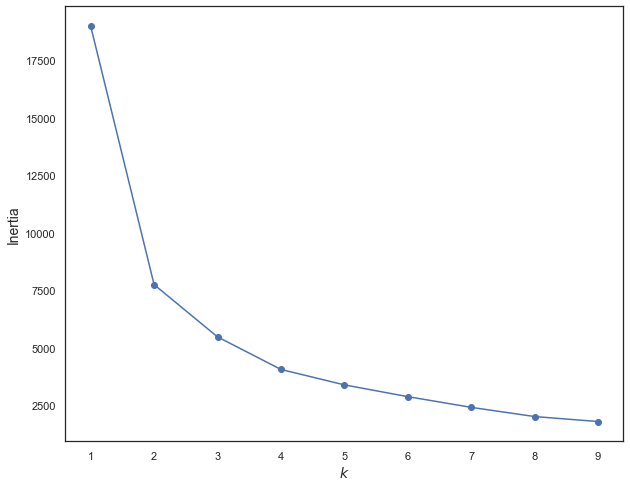

In [36]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(UMAP_bert2)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [37]:
def cluster_results(Kmeans_clusters=4):
    
    ClusterDict = {}
    dim_embeddings = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                      "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                      "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                      "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                      "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                      "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm}
    
    for key, val in dim_embeddings.items():
        ClusterDict[key] = KMeans(n_clusters=Kmeans_clusters).fit_predict(val)
        ClusterDict[key+"_hdbscan"] = hdbscan.HDBSCAN(min_samples = 30,
                           min_cluster_size=15,
                           metric = 'euclidean',
                           cluster_selection_method = 0.25,
                           cluster_selection_method = "eom").fit_predict(val)
    return ClusterDict

In [38]:
clustering_result = cluster_results()

In [39]:
clustering_result.keys()

dict_keys(['UMAP_bert1', 'UMAP_bert1_hdbscan', 'UMAP_bert1_norm', 'UMAP_bert1_norm_hdbscan', 'UMAP_bert2', 'UMAP_bert2_hdbscan', 'UMAP_bert2_norm', 'UMAP_bert2_norm_hdbscan', 'PCA_bert1', 'PCA_bert1_hdbscan', 'PCA_bert1_norm', 'PCA_bert1_norm_hdbscan', 'PCA_bert2', 'PCA_bert2_hdbscan', 'PCA_bert2_norm', 'PCA_bert2_norm_hdbscan', 'tSNE_bert1', 'tSNE_bert1_hdbscan', 'tSNE_bert1_norm', 'tSNE_bert1_norm_hdbscan', 'tSNE_bert2', 'tSNE_bert2_hdbscan', 'tSNE_bert2_norm', 'tSNE_bert2_norm_hdbscan'])

In [40]:
def plot(cluster = clustering_result):    
    reduced_dims = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                    "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                    "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                    "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                    "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                    "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm,
                    "UMAP_bert1_hdbscan" : UMAP_bert1, "UMAP_bert1_norm_hdbscan" : UMAP_bert1_norm, 
                    "UMAP_bert2_hdbscan" : UMAP_bert2, "UMAP_bert2_norm_hdbscan" : UMAP_bert2_norm,
                    "PCA_bert1_hdbscan" : PCA_bert1, "PCA_bert1_norm_hdbscan" : PCA_bert1_norm, 
                    "PCA_bert2_hdbscan" : PCA_bert2, "PCA_bert2_norm_hdbscan" : PCA_bert2_norm,
                    "tSNE_bert1_hdbscan" : tSNE_bert1, "tSNE_bert1_norm_hdbscan" :  tSNE_bert1_norm, 
                    "tSNE_bert2_hdbscan" : tSNE_bert2, "tSNE_bert2_norm_hdbscan" : tSNE_bert2_norm}

    for clustee_name, clustee in cluster.items():
        clustered = (clustee >= 0)
        reduced_dim = reduced_dims[clustee_name]
            
        print(f"----------{clustee_name}--------------------")

        unique, counts = np.unique(clustee, return_counts=True)
        print(dict(zip(unique, counts)))

        plt.scatter(reduced_dim[~clustered, 0],
                    reduced_dim[~clustered, 1],
                    c=(0.5,0.5,0.5),
                    # s=1,
                    alpha=0.5
                    )
        plt.scatter(reduced_dim[clustered, 0],
                    reduced_dim[clustered, 1],
                    c=clustee[clustered],
                    # s=1,
                    cmap='Spectral')
        plt.show()

----------UMAP_bert1--------------------
{0: 728, 1: 742, 2: 729, 3: 711}


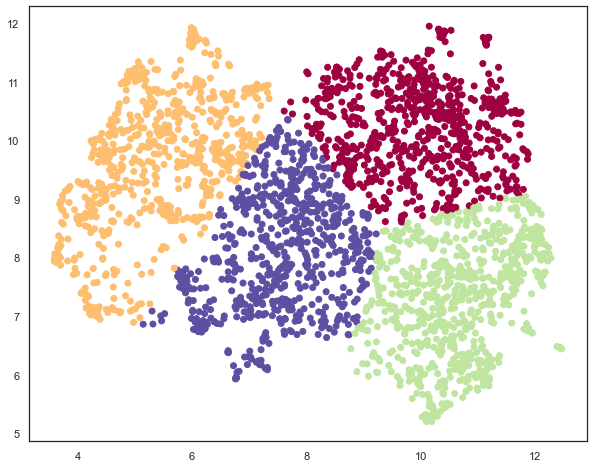

----------UMAP_bert1_hdbscan--------------------
{-1: 1256, 0: 32, 1: 41, 2: 24, 3: 25, 4: 35, 5: 28, 6: 16, 7: 26, 8: 42, 9: 52, 10: 24, 11: 15, 12: 16, 13: 400, 14: 30, 15: 44, 16: 36, 17: 42, 18: 32, 19: 25, 20: 25, 21: 119, 22: 38, 23: 22, 24: 17, 25: 197, 26: 17, 27: 66, 28: 100, 29: 50, 30: 18}


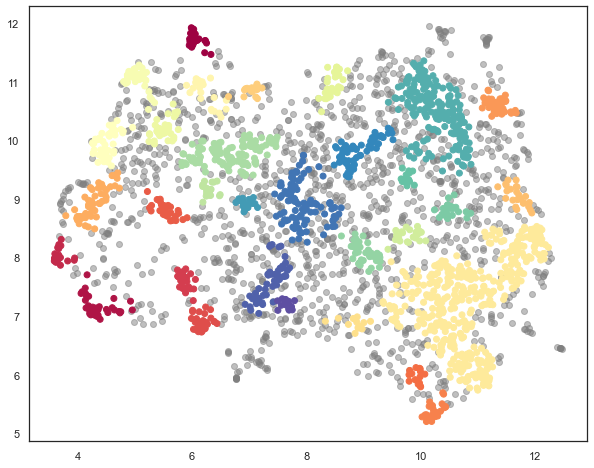

----------UMAP_bert1_norm--------------------
{0: 714, 1: 749, 2: 736, 3: 711}


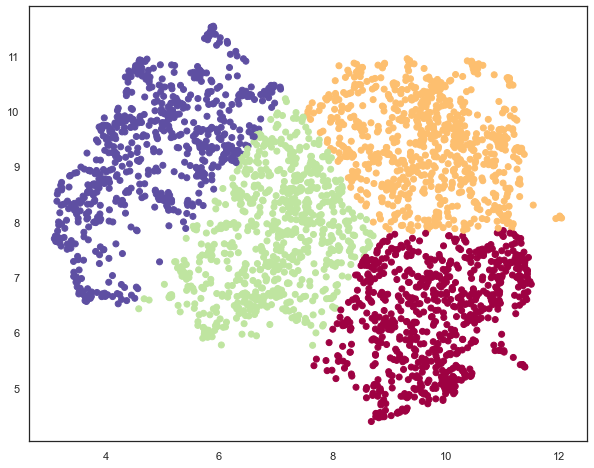

----------UMAP_bert1_norm_hdbscan--------------------
{-1: 58, 0: 32, 1: 2820}


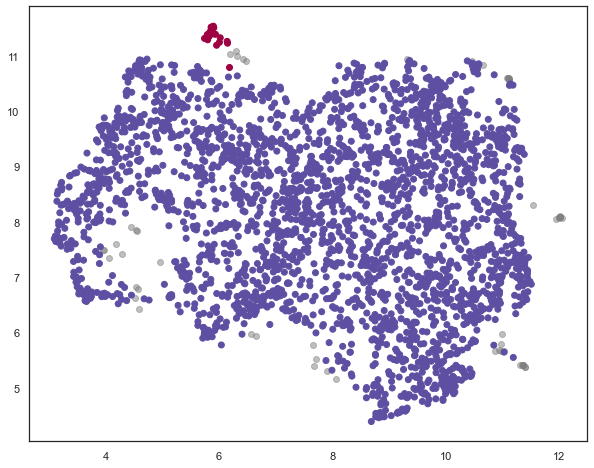

----------UMAP_bert2--------------------
{0: 534, 1: 698, 2: 603, 3: 1075}


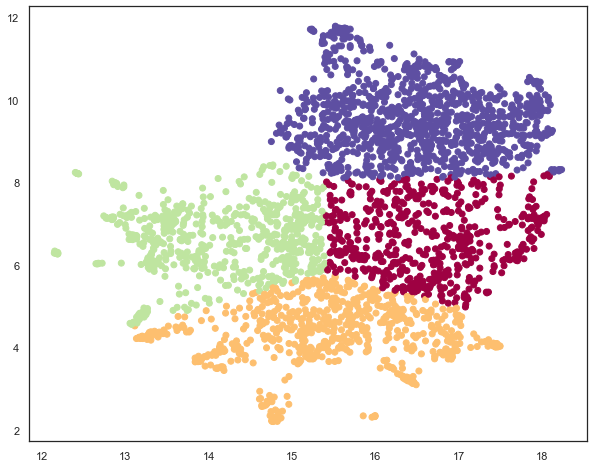

----------UMAP_bert2_hdbscan--------------------
{-1: 40, 0: 43, 1: 2827}


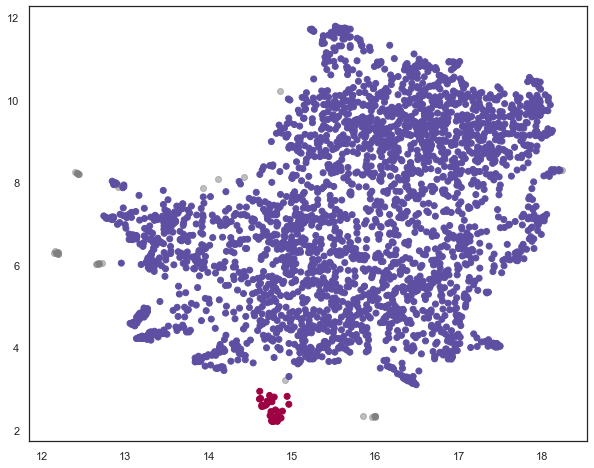

----------UMAP_bert2_norm--------------------
{0: 648, 1: 660, 2: 568, 3: 1034}


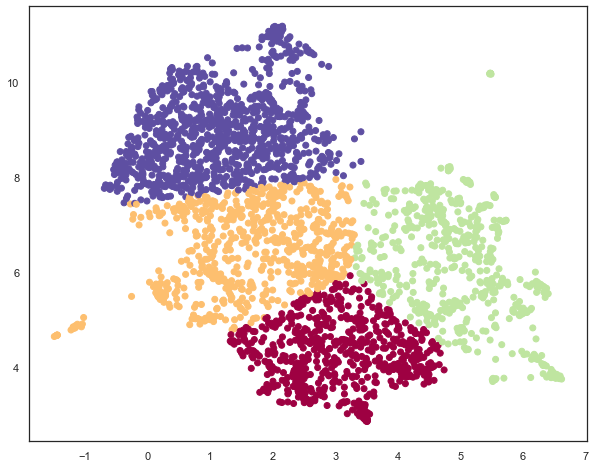

----------UMAP_bert2_norm_hdbscan--------------------
{-1: 8, 0: 22, 1: 2880}


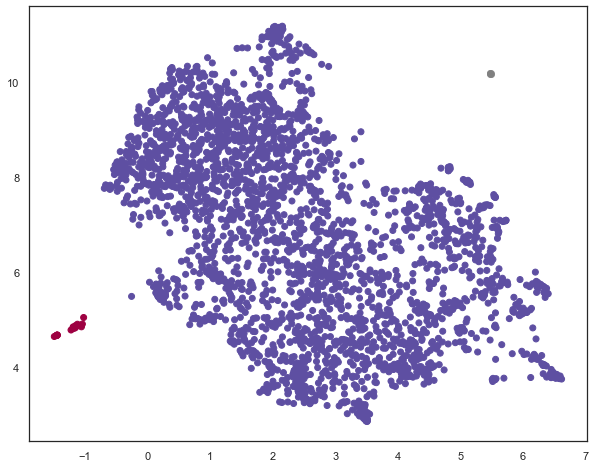

----------PCA_bert1--------------------
{0: 937, 1: 740, 2: 282, 3: 951}


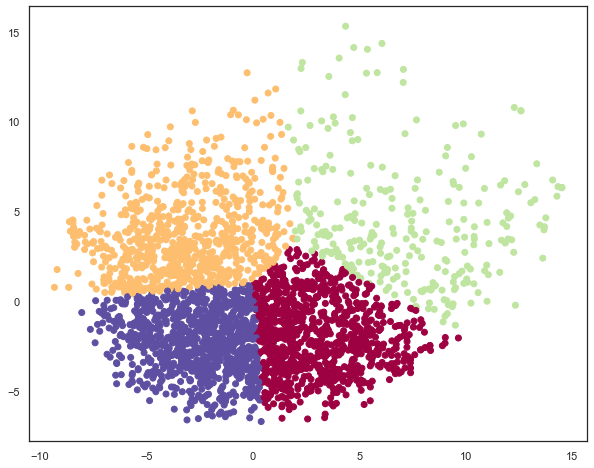

----------PCA_bert1_hdbscan--------------------
{-1: 1087, 0: 1803, 1: 20}


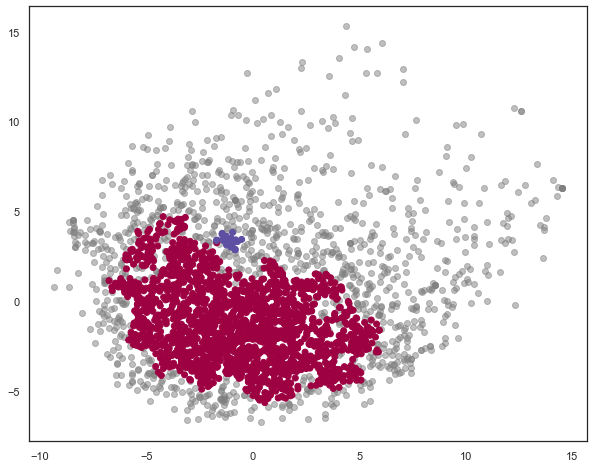

----------PCA_bert1_norm--------------------
{0: 974, 1: 687, 2: 938, 3: 311}


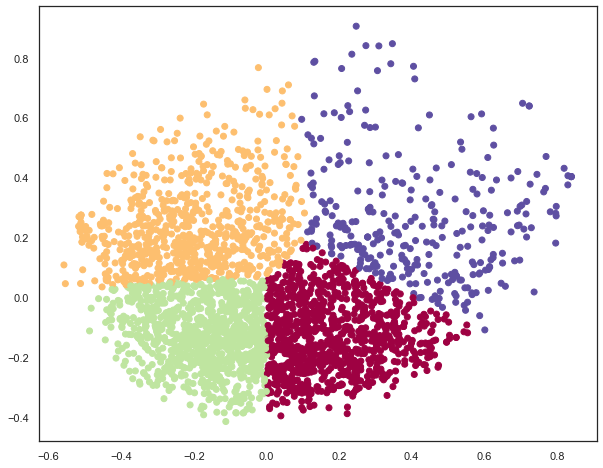

----------PCA_bert1_norm_hdbscan--------------------
{-1: 1445, 0: 28, 1: 19, 2: 1418}


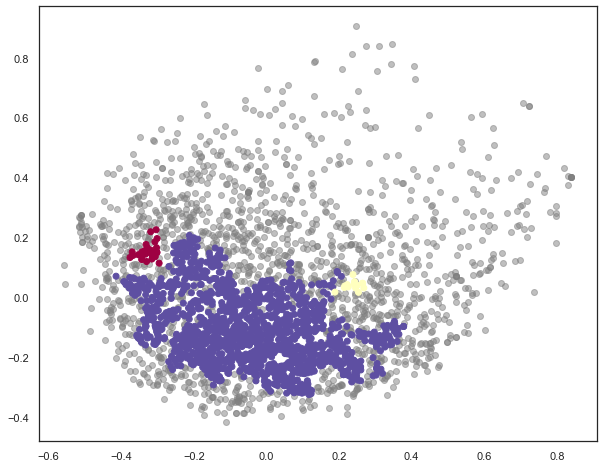

----------PCA_bert2--------------------
{0: 447, 1: 772, 2: 680, 3: 1011}


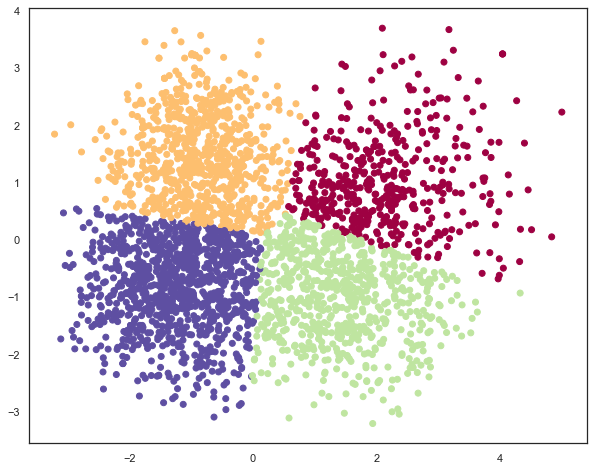

----------PCA_bert2_hdbscan--------------------
{-1: 1330, 0: 57, 1: 28, 2: 297, 3: 1198}


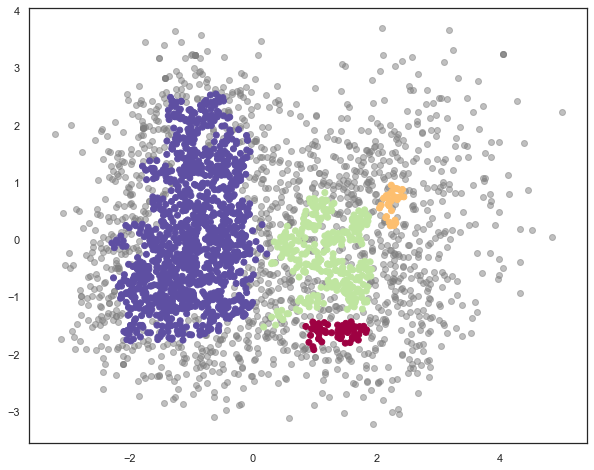

----------PCA_bert2_norm--------------------
{0: 1009, 1: 491, 2: 768, 3: 642}


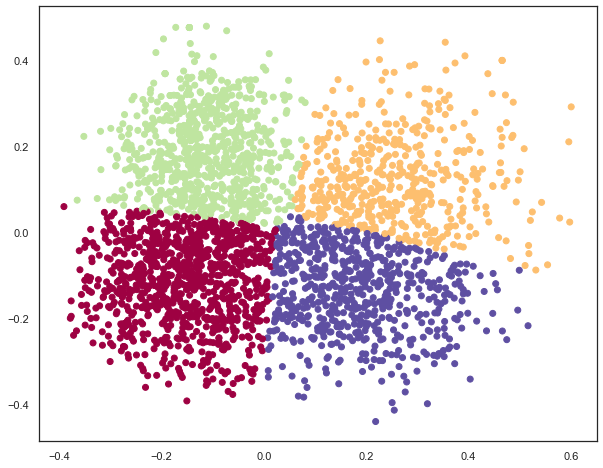

----------PCA_bert2_norm_hdbscan--------------------
{-1: 1510, 0: 28, 1: 15, 2: 23, 3: 1132, 4: 103, 5: 31, 6: 20, 7: 48}


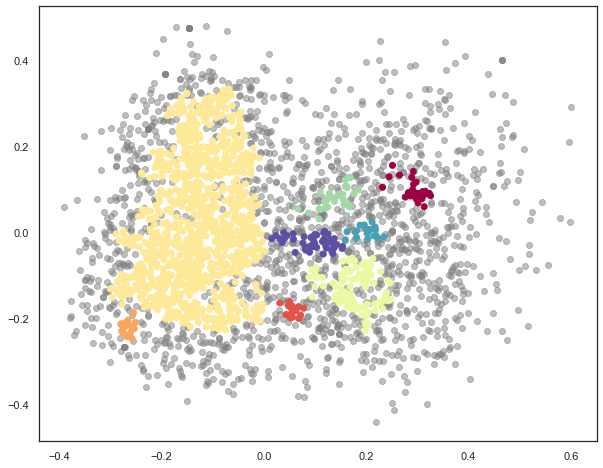

----------tSNE_bert1--------------------
{0: 632, 1: 832, 2: 640, 3: 806}


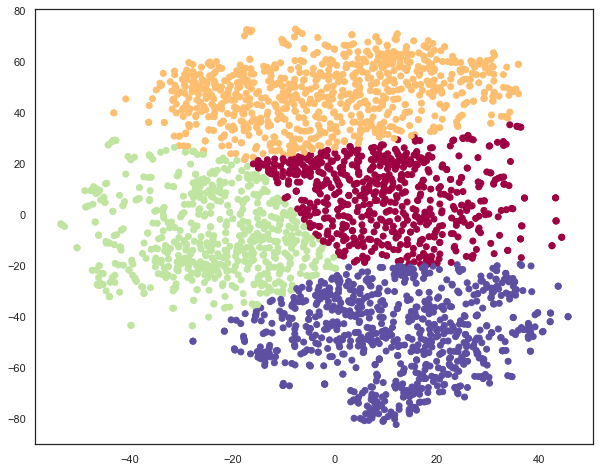

----------tSNE_bert1_hdbscan--------------------
{-1: 208, 0: 16, 1: 2686}


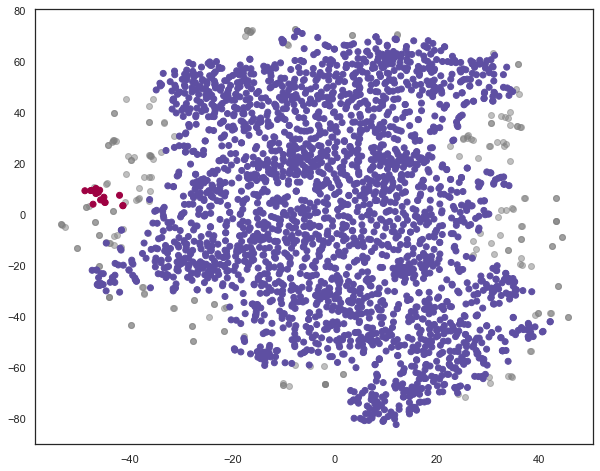

----------tSNE_bert1_norm--------------------
{0: 842, 1: 772, 2: 733, 3: 563}


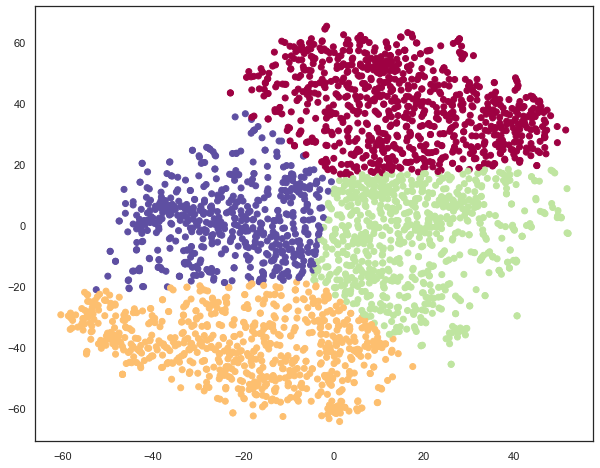

----------tSNE_bert1_norm_hdbscan--------------------
{-1: 360, 0: 15, 1: 2520, 2: 15}


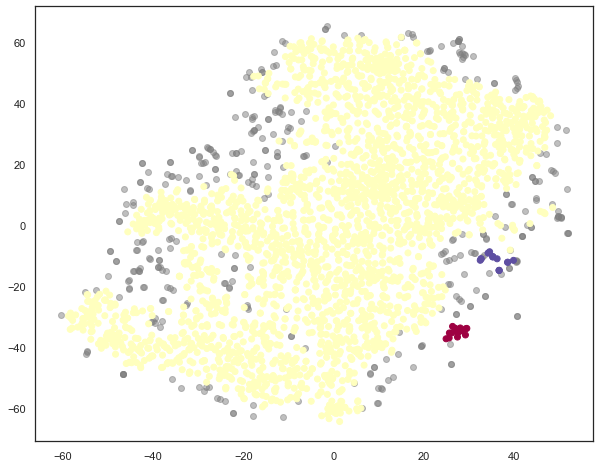

----------tSNE_bert2--------------------
{0: 619, 1: 954, 2: 741, 3: 596}


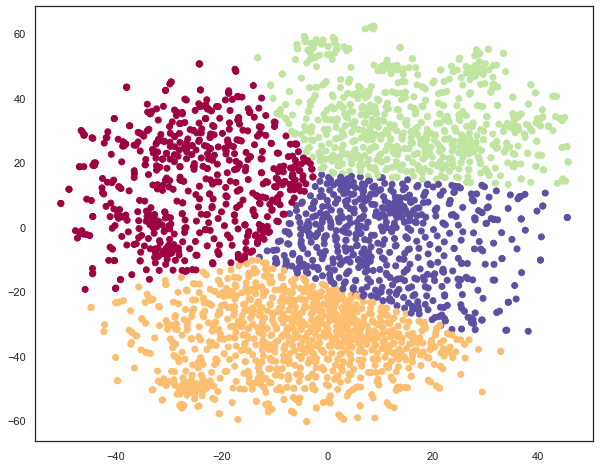

----------tSNE_bert2_hdbscan--------------------
{-1: 258, 0: 2607, 1: 45}


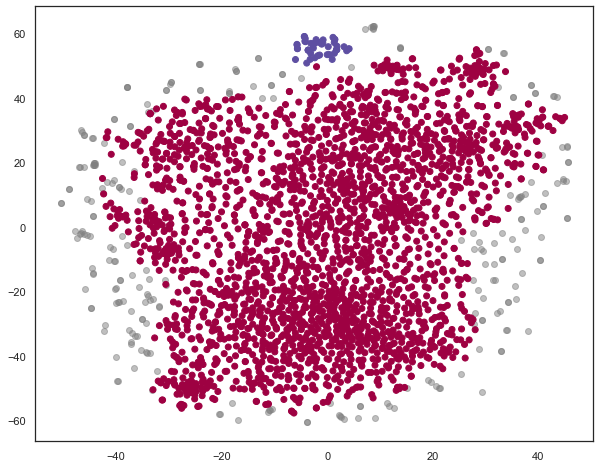

----------tSNE_bert2_norm--------------------
{0: 711, 1: 837, 2: 813, 3: 549}


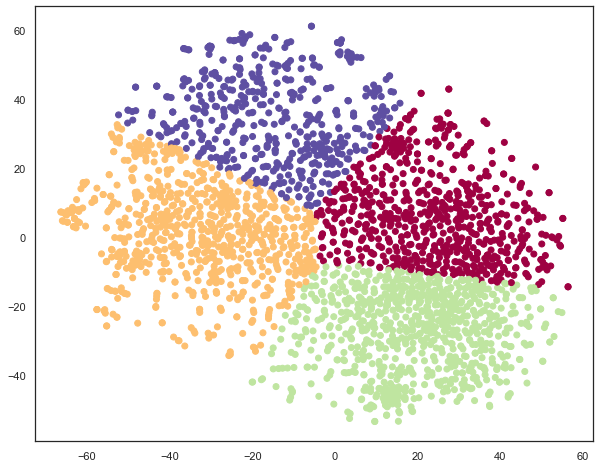

----------tSNE_bert2_norm_hdbscan--------------------
{-1: 161, 0: 21, 1: 2728}


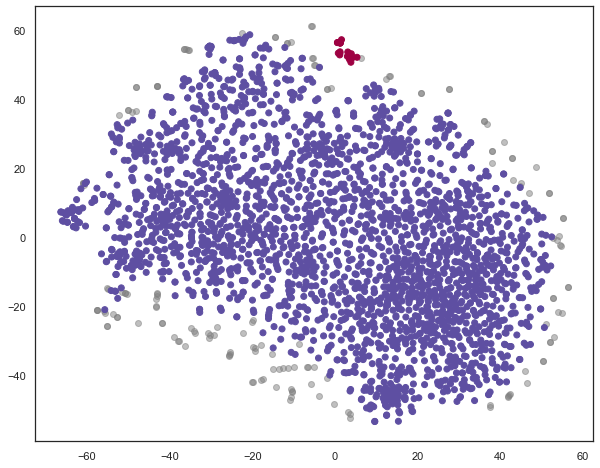

In [41]:
plot()

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfmatrix(data, vectorizer):
    terms = vectorizer.fit_transform(data)
    return pd.DataFrame(terms.toarray(), columns = vectorizer.get_feature_names())

In [53]:
def cluster_words(clustering_result=clustering_result, top_n = 20, show_cross = False):
    for name, value in clustering_result.items():
        print(f"===================================={name}=============================================")
    
        #creatin new df in order to groupby same clusters
        cluster = value
        docs = pd.DataFrame(df_clean)
        docs["cluster"] = cluster

        labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"tweet": " ".join})

        try : 
            del labeled_docs_try
        except :
            pass
        labeled_docs_try =pd.DataFrame(df_clean)
        labeled_docs_try["labels"] = df.labels
        labeled_docs_try["cluster"] = docs.cluster
        labeled_docs_try.head(50)
        cross = pd.crosstab(labeled_docs_try.labels, labeled_docs_try.cluster)
        if show_cross:
            display(cross)
        else: pass
                
        tfidf_vec = TfidfVectorizer()
        tfidf_mat = tfidfmatrix(labeled_docs.tweet, tfidf_vec)
        
        global most_common
        most_common = pd.DataFrame({n: tfidf_mat.T[col].nlargest(top_n).index.tolist() 
                                for n, col in enumerate(tfidf_mat.T)}).T
        most_common.index = np.unique(cluster)
        display(most_common)

In [54]:
cluster_words(show_cross = False)

====================================UMAP_bert1=============================================


0         1        2      3      4       5        6   \
0  bounce_back_loan     apply      day   week  still    wait  account   
1             thank     hello   please   send   team    help     call   
2  bounce_back_loan  customer  nothing  apply    bad    call      day   
3  bounce_back_loan   account    hello  thank  email  please    apply   

         7        8            9         10      11       12           13  \
0     email     call  application      sign    hour      say        thank   
1    detail   kindly        check        dm  number  message       assist   
2  business  account          say     still    time     year         help   
3  customer     help          say  business    call      pay  application   

               14           15     16           17        18     19  
0            time         back  today          pay  customer   take  
1            need  hello_thank  phone  information      look  share  
2         service        email   tell        money      make   wait  
3  feeder_account           nt   back          see      send  money

====================================UMAP_bert1_hdbscan=============================================


0                 1           2           3             4   \
-1   bounce_back_loan           account       thank       apply         hello   
 0         refer_link            assist       hence        call         phone   
 1           complain              link        form   complaint            dm   
 2              thank          generous       reply          ok       needful   
 3   bounce_back_loan              good        luck     exactly       revolut   
 4   bounce_back_loan        lloydsbank       block    hightonk   philpelucha   
 5            support             thank   yorkshire        work         award   
 6   bounce_back_loan              word         bad         due       abigail   
 7                bad           service    customer    shocking          poor   
 8             monday  bounce_back_loan     tuesday       apply        friday   
 9              thank              glad  appreciate        help         great   
 10           nothing  bounce_back_loan       apply        week      week_ago   
 11               day              work        team       thank          next   
 12            cartel              drug  laundering       money         fraud   
 13  bounce_back_loan          customer         bad     nothing      business   
 14             fetch            hsbcsm          sm        send      priority   
 15            kindly              team       hello  appreciate        nilesh   
 16     inconvenience             hello       sorry       thank        please   
 17         full_name                dm       hello       thank        please   
 18             still  bounce_back_loan  still_wait       apply          sign   
 19              sony           nigeria    unilever    hongkong      michelin   
 20              scam               zar  screenshot       share    click_link   
 21             thank             hello       email        link        please   
 22  bounce_back_loan             email        tide        same          stop   
 23             email  bounce_back_loan     nothing     without           say   
 24             seven               oct       rugby   singapore  hubsingapore   
 25  bounce_back_loan              week    week_ago       apply          wait   
 26            online           website     account      saving         hello   
 27  bounce_back_loan       application         day    thousand         apply   
 28  bounce_back_loan             email     account         say           ceo   
 29  bounce_back_loan  personal_account      global       libra      customer   
 30  bounce_back_loan             debit       money     account          card   

                   5           6            7                8   \
-1                day        call         help            email   
 0            request       order      service      information   
 1               send      beread      curious        doesthank   
 2                âœœ          ah      awesome            bless   
 3      beckleyfamily       lloyd    wanksylol             same   
 4                 oh        same        alfff            ambik   
 5              nhsuk      future      package           across   
 6    accordinglyalpa    allerton   brynbadger  chrislblackwell   
 7              awful        help   absolutely             ever   
 8              email   wednesday         last             sign   
 9           feedback       share      welcome     feedbackalpa   
 10      hear_nothing       never         hour             sign   
 11      good_morning       query         care         possible   
 12         financial  fraudulent      against             jail   
 13             apply        call         year         absolute   
 14            number   concerned     register           mobile   
 15           concern      revert     patience          youalpa   
 16           apology  link_below      message            cause   
 17        link_below       check         look      accordingly   
 18  

====================================UMAP_bert1_norm=============================================


0         1        2      3      4       5         6   \
0  bounce_back_loan  customer  nothing  apply    bad    call  business   
1  bounce_back_loan     apply      day   week  still    wait     email   
2  bounce_back_loan   account    thank  hello   help  please     email   
3             thank     hello   please   send   team    help      call   

               7       8            9       10           11      12  \
0         account     day         time     say      service   still   
1         account    call  application     say         sign    hour   
2  feeder_account   apply     customer    call  application     pay   
3          kindly  detail        check  assist           dm  number   

               13         14    15           16       17       18     19  
0  feeder_account       help  year        thank    email     make    try  
1            time      thank  back           nt    today      pay   last  
2        business        say  need        money      see  receive   send  
3         message  full_name  need  hello_thank  concern    phone  share

====================================UMAP_bert1_norm_hdbscan=============================================


0      1        2      3           4        5          6   \
-1              gold  covid  nigeria   sony      market      gld  infection   
 0            assist   call  service   need  refer_link  request      hence   
 1  bounce_back_loan  thank  account  email       apply    hello        day   

             7            8        9            10        11       12  \
-1     hongkong         amid  england        happy     query  turmoil   
 0  information        phone    order  hello_thank   concern   regard   
 1     customer  application    still       please  business     send   

          13      14      15       16      17     18        19  
-1  unilever  airbus    ford   toyota     bar   case  michelin  
 0      team   hello  nilesh  writing  number  thank   barnali  
 1      wait    call    help     time    week    say      back

====================================UMAP_bert2=============================================


0         1               2        3      4      5       6   \
0              call  customer           thank  account    try  hello     day   
1             thank     hello          please     send   team   help  kindly   
2           account     thank           covid    money   help    new    gold   
3  bounce_back_loan     apply  feeder_account      day  email   week    sign   

      7            8        9       10       11        12                13  \
0   hour         time  service    wait    apply    please  bounce_back_loan   
1   call       assist       dm  detail  message    number        link_below   
2  hello  credit_card      pay    make  payment      sony           support   
3   wait  application  account   still      say  business          customer   

         14           15      16       17     18     19  
0     phone  application   still   minute   help   tell  
1     check         back   share  request  sorry  email  
2  transfer       market  please     card    use   need  
3      call         back    time  nothing   tell   take

====================================UMAP_bert2_hdbscan=============================================


0        1         2        3         4             5   \
-1             covid  nigeria      sony     gold  unilever      hongkong   
 0             query   assist     happy       jp       day  good_morning   
 1  bounce_back_loan    thank  customer  account     email         apply   

          6          7         8          9         10       11    12  \
-1  michelin  moneygram       gld  infection    market  million  help   
 0   morning   everyone  tomorrow       help     today    great  hope   
 1     hello     please      call       send  business    phone  wait   

         13      14           15        16    17       18        19  
-1  england  airbus          bmw  burberry  ford   toyota       new  
 0    thank   tweet         back        zs   nzt  evening  thursday  
 1      day    take  application       say  help    still      tell

====================================UMAP_bert2_norm=============================================


0         1                 2     3               4   \
0             hello     thank            please  team            call   
1           account  customer  bounce_back_loan  call     application   
2             thank     covid             hello  help            send   
3  bounce_back_loan     apply             email   day  feeder_account   

        5            6        7           8                 9         10  \
0     send         help       dm      number            kindly    detail   
1    thank          day    apply        wait               say      time   
2  support         scam    happy  screenshot  phishinghsbccouk    please   
3     week  application  account       still              wait  business   

       11         12        13       14          15      16       17       18  \
0  assist  full_name     check    sorry  link_below  nilesh     need  request   
1     try     please     hello     make        tell    help  service    still   
2     see      today      text  nigeria        safe    link     asia      zar   
3     say       sign  customer  nothing        back    time     help     take   

            19  
0  information  
1         hour  
2       branch  
3           nt

====================================UMAP_bert2_norm_hdbscan=============================================


0       1        2        3      4       5             6   \
-1       doubledigit    asia    asset   growth    see  wealth  neweconomygr   
 0              gold  market  turmoil      gld   lose    amid       england   
 1  bounce_back_loan   thank    hello  account  apply  please          call   

          7            8      9             10           11              12  \
-1    reuter  aarogyasetu  aaron  aaronsneddon  aascaffolde  aasmohammadind   
 0   million          bar    day           tap        break        physical   
 1  customer         help  email          send          day            wait   

           13       14           15             16        17        18  \
-1    abandon  abanind    abbievdub  abbyschofield  abdulbvb  abdullah   
 0  dislocate   around        covid         happen    london     march   
 1       time     week  application            say     still      team   

               19  
-1  abhishekcmrit  
 0          paper  
 1           need

====================================PCA_bert1=============================================


0         1                 2        3                 4   \
0             thank     hello  bounce_back_loan   please              send   
1  bounce_back_loan  customer             apply     week           nothing   
2             thank    please             hello     help  bounce_back_loan   
3  bounce_back_loan     email             apply  account               day   

     5      6        7            8         9       10    11        12  \
0  team   help     call      account    kindly  number  need    assist   
1   bad    day  account     business      call   still   say     money   
2  send  still     time          bad  customer    give  make      need   
3  week   call     wait  application     thank     say  help  customer   

        13     14     15       16      17        18       19  
0    email   look  check       dm  detail   request  message  
1     time   year   wait  service     try      take      pay  
2  account     be    day       dm    know     reply     safe  
3   please  still   time     back   hello  business       nt

====================================PCA_bert1_hdbscan=============================================


0        1      2         3       4        5        6   \
-1  bounce_back_loan    thank  hello  customer   apply  account    email   
 0  bounce_back_loan  account  thank     hello  please    email    apply   
 1  bounce_back_loan   around    ask   dispute    rate    today  deficit   

        7      8          9       10    11        12      13       14      15  \
-1    call    day       week  please  help  business    time  receive     say   
 0    call    day       help    team  week  customer    send       nt    wait   
 1  resent  shift  anneboden   apply  back      call  charge  connect  crisis   

             16    17        18    19  
-1  application   bad      take  team  
 0       number  take  business  back  
 1          day    dm      else   gdp

====================================PCA_bert1_norm=============================================


0         1                 2        3                 4   \
0             thank     hello  bounce_back_loan   please              team   
1  bounce_back_loan  customer             apply      bad           nothing   
2  bounce_back_loan     email             apply  account              week   
3             thank     hello              help   please  bounce_back_loan   

     5     6     7            8        9         10        11     12     13  \
0  send  help  call      account   number    kindly      need  email   look   
1   day  week  call     business  account     still       say  money   year   
2   day  call  wait  application      say      help  customer  still  thank   
3  send   cir  time           dm    still  customer      give   know    bad   

       14       15    16        17           18        19  
0  assist    check  back    detail           dm  customer  
1    time  service  wait       try  application      need  
2    time   please  back  business         sign     hello  
3      be     make  need      safe      account      call

====================================PCA_bert1_norm_hdbscan=============================================


0         1        2         3       4       5      6   \
-1  bounce_back_loan     thank    hello  customer     day  please  apply   
 0  bounce_back_loan  customer      bad   nothing      nt    call   make   
 1       doubledigit      asia    asset    growth  wealth     see  hello   
 2  bounce_back_loan     thank  account    please   hello   email    day   

         7         8          9         10      11      12                13  \
-1  account      call      email      help    week     say              time   
 0     wait      week      apply   account  answer    back              come   
 1    thank  let_know  name_post        re   sorry  assist  bounce_back_loan   
 2     send     apply       call  customer    help    wait              team   

      14           15      16        17       18           19  
-1  wait  application   still  business     give         back  
 0   off          pay  people     phone  promise         tell  
 1    dm         help   speak     alfff    ambik  anasmvstafa  
 2  back  application    time       say    still         week

====================================PCA_bert2=============================================


0        1        2      3               4            5   \
0  bounce_back_loan     week  account  apply  feeder_account     business   
1             thank  account    covid  money            gold         help   
2  bounce_back_loan    apply    email    day            wait  application   
3             thank    hello   please   call            team         send   

         6        7         8         9       10              11       12  \
0  customer      pay     still       day     say           money     loan   
1       new  support      sony    please  market            look      see   
2      call     week   account  customer     say  feeder_account     sign   
3      help  account  customer    number  kindly            need  service   

       13        14     15      16     17    18       19  
0    take      give   back      nt   sign  wait     good  
1     bad  business  hello      nt   back  time       be  
2   still  business   time    tell  phone  back  receive  
3  assist   message  phone  detail    try  time  request

====================================PCA_bert2_hdbscan=============================================


0        1        2        3            4               5   \
-1  bounce_back_loan    thank    apply    hello         call             day   
 0  bounce_back_loan     call    apply    email  application             day   
 1  bounce_back_loan  account    apply     week     business  feeder_account   
 2  bounce_back_loan    apply  account    email          day        customer   
 3             thank    hello   please  account         team            send   

       6               7            8        9               10        11  \
-1  email          please         wait     help            week  customer   
 0   year  feeder_account         wait  connect        customer     every   
 1  money          anyone  application      day            good      hear   
 2   wait             say         sign     week  feeder_account     still   
 3   help        customer      service     call            time    kindly   

       12           13        14       15      16            17  \
-1  phone  application   account     send   still          team   
 0   week          bad    minute  nothing   phone      business   
 1   last         next       set     sign    wait  craigremoval   
 2   fund  application  business     take  please            nt   
 3   card        share      need     back   sorry          make   

                 18       19  
-1              say     back  
 0       experience   second  
 1  radioseducation   thewvb  
 2             call     need  
 3               dm  receive

====================================PCA_bert2_norm=============================================


0      1        2      3         4            5   \
0             thank  hello   please   call      team         send   
1  bounce_back_loan   week  account  apply  business     customer   
2             thank  covid  account   help      gold        money   
3  bounce_back_loan  apply    email    day      wait  application   

               6        7         8         9               10     11  \
0            help  account  customer    number          kindly   need   
1  feeder_account      day       say     still             pay  money   
2         support     sony       new    please          market   look   
3            call  account      week  customer  feeder_account    say   

        12       13        14      15        16       17      18        19  
0  message  service     phone  detail       try     time  assist      back  
1     take     give      loan    wait      sign       nt   today      back  
2      see       be      time     bad  business  nigeria    back  customer  
3    still     sign  business    time     phone     back    tell   receive

====================================PCA_bert2_norm_hdbscan=============================================


0                 1          2            3   \
-1  bounce_back_loan             apply      thank         call   
 0  bounce_back_loan              week    account     business   
 1             apply  bounce_back_loan       wait        email   
 2            kindly            number       team        hello   
 3             thank             hello     please      account   
 4  bounce_back_loan             email        day  application   
 5  bounce_back_loan             swoop    coconut         week   
 6  bounce_back_loan          business  yesterday          day   
 7  bounce_back_loan             apply       well        email   

                 4                5         6             7        8   \
-1              day            email     hello          wait   please   
 0  cryptotradinguk  natwestbusiness      next          wait  arehsbc   
 1           people          account  customer         lodge     back   
 2             alpa           assist      send     concerned       sm   
 3             help          service      team          send   branch   
 4            apply             call      wait          make     tell   
 5             fund          account      come          make    maybe   
 6            email          account   nothing         apply      new   
 7              day              why  transfer  hear_nothing    money   

          9        10              11        12         13              14  \
-1      week  account     application      help   customer           still   
 0  customer     face  removalsroyton     money       sign         balance   
 1       use      ago            wife      call  complaint  feeder_account   
 2     fetch   hsbcsm          mobile  priority   register      refer_link   
 3  customer       dm            call      card       back            make   
 4       say     sign           still      week       back          update   
 5      pull    those            back     money       deal            down   
 6  customer  protect          whilst     would        pay             acc   
 7      take  account            hear     never        see             ceo   

              15        16              17                18              19  
-1           say      back  feeder_account          business            take  
 0  craigremoval      love          option          personal           screw  
 1           say     thank              be  personal_account              re  
 2          call     check         request            detail     hello_thank  
 3          look     covid           check              well            time  
 4          work  business        customer             phone         nothing  
 5          last       non           apply              need             say  
 6       finally    lloyds    martinslewis              most  feeder_account  
 7           say       try           seiss              sign            tell

====================================tSNE_bert1=============================================


0         1       2        3         4      5      6   \
0  bounce_back_loan       day   apply  account     thank   week  email   
1  bounce_back_loan  customer   apply  nothing      week    day   call   
2  bounce_back_loan   account   apply    email  customer  hello  still   
3             thank     hello  please     send      help   team   call   

        7      8            9      10           11      12              13  \
0     call   wait  application   time        hello    back          please   
1  account  still     business    bad          say    wait           email   
2   please    say        thank  money  application    help  feeder_account   
3   kindly  check       detail     dm      message  number          assist   

     14         15           16       17           18     19  
0    nt       hour      receive    today          say   open  
1  year       time  application     help         take  money  
2  wait       call          pay  receive     business   back  
3  need  full_name         look    phone  hello_thank  sorry

====================================tSNE_bert1_hdbscan=============================================


0       1      2           3        4      5        6   \
-1             thank   covid  hello        help  support    new  nigeria   
 0             money  cartel   drug  laundering    fraud     he     jail   
 1  bounce_back_loan   thank  email       apply   please  hello     help   

           7                 8          9        10     11              12  \
-1       time  bounce_back_loan       busy  resolve   sony           today   
 0  terrorist              case  financial     fine  thank  administration   
 1    account              call        day     wait   send        customer   

            13           14       15        16       17       18    19  
-1    customer      account     call     issue  million     need    nt  
 0  department      involve  launder    matter   recent  against  also  
 1        week  application    still  business     need    phone    nt

====================================tSNE_bert1_norm=============================================


0         1        2        3      4               5   \
0  bounce_back_loan  customer  nothing    apply    day             bad   
1             thank     hello   please     send   help            team   
2  bounce_back_loan     email    apply  account    day            call   
3  bounce_back_loan   account    apply    thank  hello  feeder_account   

            6       7         8       9        10        11      12        13  \
0         week    call  business   still  account       say    wait     money   
1         call  kindly    detail  number    check      need  assist        dm   
2  application   thank      week  please    hello      time    wait  customer   
3     business    wait       day   money      say  customer  please     still   

        14       15     16           17     18       19  
0     help     take   time           nt   tell  service  
1  message  account  share  hello_thank   look    phone  
2  receive     back    say         help  still       nt  
3      pay     help    see         take   time     asia

====================================tSNE_bert1_norm_hdbscan=============================================


0                 1                 2      3        4   \
-1             thank             hello  bounce_back_loan  covid     time   
 0               she  bounce_back_loan           account   wife     call   
 1  bounce_back_loan             thank             hello  apply  account   
 2             query             happy            assist  thank   sunday   

          5        6        7         8      9       10     11    12       13  \
-1  customer     gold  account      call    new  market    day    be    today   
 0       say     wait      her      lady   tell    name    ask  back    check   
 1      call     send    email  customer   week  please  still   day     wait   
 2   weekend  midweek    great      hope  today      jp   help   see  evening   

              14           15        16        17    18    19  
-1         issue       people    please      back  need    nt  
 0          time     transfer  computer  daughter  each  hang  
 1          help  application        nt   receive   say  back  
 2  good_morning      morning   twitter       fun    ks  plan

====================================tSNE_bert2=============================================


0      1                 2         3      4               5   \
0          customer   call             covid  business  thank         service   
1  bounce_back_loan  apply             email       day   week  feeder_account   
2             thank  hello            please      team   send            help   
3           account  thank  bounce_back_loan       day  apply           hello   

            6        7                 8            9         10        11  \
0          bad     gold  bounce_back_loan         hour      time       new   
1  application  account              wait        still  customer  business   
2         call   assist            kindly  hello_thank    detail    number   
3         call   please       application          say      tell     still   

      12       13     14          15       16       17      18           19  
0   help     sony  money      market  support  account  minute         year  
1   sign      say   back        help  nothing       nt    time         hear  
2     dm  message  check  link_below   nilesh    sorry    back  information  
3  email    money    try        wait     help      pay    sign         week

====================================tSNE_bert2_hdbscan=============================================


0      1        2      3        4             5         6   \
-1  bounce_back_loan   sony    thank    say  nigeria         covid     apply   
 0  bounce_back_loan  thank  account  hello    apply          call  customer   
 1             query  happy   assist     jp      day  good_morning      help   

       7        8      9      10           11     12    13        14  \
-1   call     hour   help     be        email   last  look     today   
 0  email   please   send    day  application   help  team       say   
 1  today  morning  thank  great         hope  tweet    zs  everyone   

          15    16       17        18       19  
-1      give   new   please  unilever    china  
 0  business  wait       nt      take  receive  
 1  tomorrow   nzt  evening      back       bl

====================================tSNE_bert2_norm=============================================


0        1         2     3               4         5   \
0  bounce_back_loan  account     apply   day        customer  business   
1             thank    hello    please  call            team      send   
2  bounce_back_loan    apply     email   day  feeder_account       say   
3             thank    covid  customer  help     credit_card      gold   

            6       7            8        9        10      11       12  \
0  application    wait         week    thank    still  please     fund   
1         help  assist       number   detail   kindly      dm  message   
2         call    week  application  account     sign   still  nothing   
3      service   hello        money      new  support    card   please   

       13    14          15        16       17       18              19  
0    take  time        help      loan     need  receive  feeder_account  
1   phone  need  link_below      back  request    check     information  
2    wait  back        tell  customer    phone     time           today  
3  market   pay        time    branch  account      bad         nigeria

====================================tSNE_bert2_norm_hdbscan=============================================


0       1        2        3          4        5        6   \
-1  bounce_back_loan   today      see  account  singapore      why    happy   
 0              gold  market  turmoil      gld       amid  england  million   
 1  bounce_back_loan   thank    hello  account      apply   please     call   

          7     8      9        10           11     12        13      14  \
-1      hear   new    oct  speaker  application     be   economy    line   
 0       bar   tap   lose      day    dislocate  break  physical  around   
 1  customer  help  email      day         send   wait      time    week   

         15           16     17     18              19  
-1  morning         need  think     ve            year  
 0   happen       london  march  paper           covid  
 1      say  application  still   team  feeder_account